runned!
['PCA', 'SMOTE', 'SimpleImputer', 'StandardScaler', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_pca_table', 'np', 'pca_on_train_and_transform_full_data', 'pd', 'plt', 'preprocess_and_apply_smote1', 'remove_outliers_iqr', 'scale_columns1']


<ipython-input-1-16303babf81f>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = y_train.replace({'1': 1, '4': 0})
<ipython-input-1-16303babf81f>:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = y_val.replace({'1': 1, '4': 0})
<ipython-input-1-16303babf81f>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_

Perc rows removed class 1: 0.14428088463163827
Perc rows removed class 0: 0.12013093289689035
Perc rows removed class 1: -0.17638585950039096
Perc rows removed class 0: -0.07412574404761904
Data has been split, outliers removed, and data scaled.
              precision    recall  f1-score   support

           0       0.78      0.46      0.58      4071
           1       0.80      0.94      0.87      9379

    accuracy                           0.80     13450
   macro avg       0.79      0.70      0.72     13450
weighted avg       0.80      0.80      0.78     13450



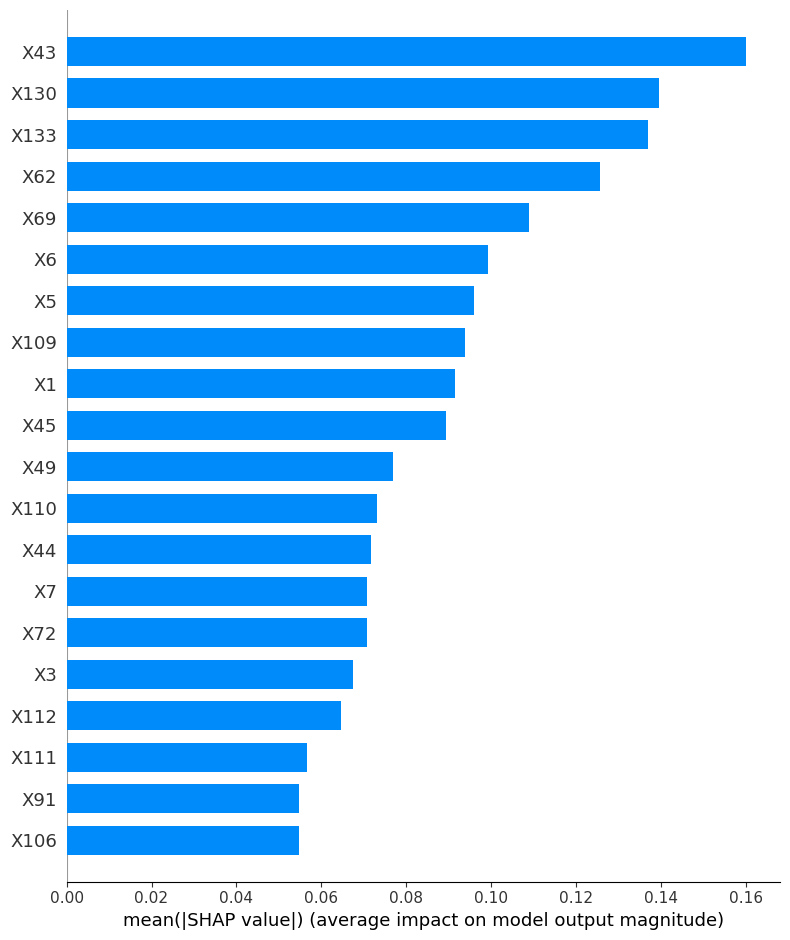

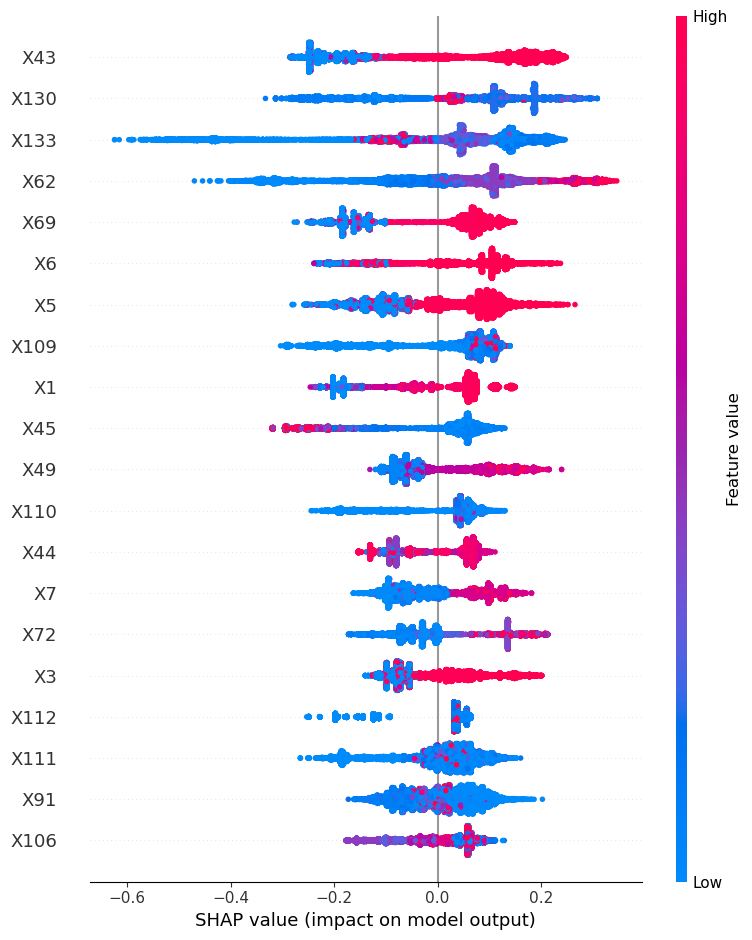

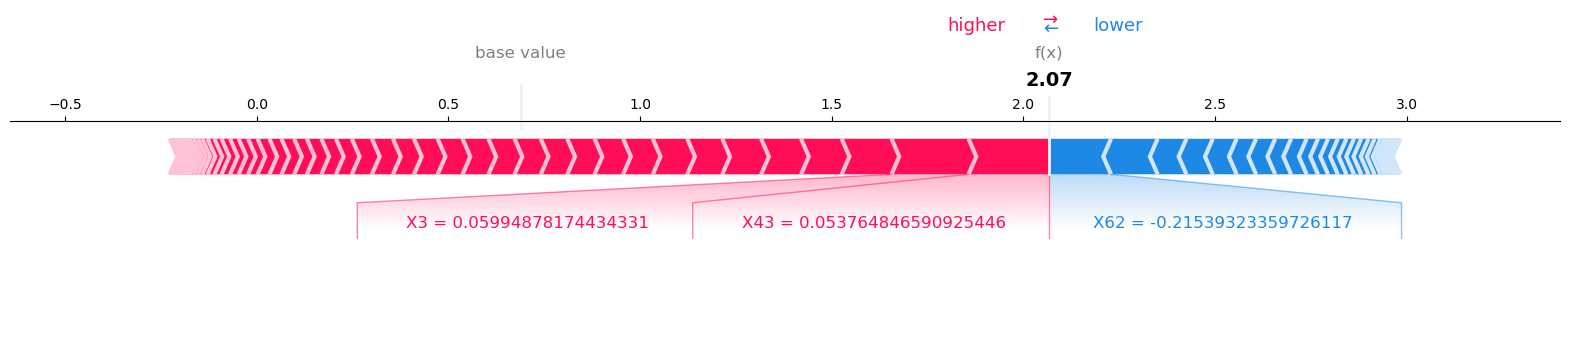

Elapsed time: 1.9085 seconds


In [ ]:
from base2 import *
from sklearn.preprocessing import LabelEncoder
import shap
shap.initjs()

# data
X_train_1 = pd.read_csv('csv/X_train.csv', index_col='Unnamed: 0')
y_train = pd.read_csv('csv/y_train.csv', index_col='Unnamed: 0')
X_val_1 = pd.read_csv('csv/X_val.csv', index_col='Unnamed: 0')
y_val = pd.read_csv('csv/y_val.csv', index_col='Unnamed: 0')
X_test_1 = pd.read_csv('csv/X_test.csv', index_col='Unnamed: 0')
y_test = pd.read_csv('csv/y_test.csv', index_col='Unnamed: 0')
y_train = (y_train['auop']).astype(str)
y_val = (y_val['auop']).astype(str)
y_test = (y_test['auop']).astype(str)
y_train = y_train.replace({'1': 1, '4': 0})
y_val = y_val.replace({'1': 1, '4': 0})
y_test = y_test.replace({'1': 1, '4': 0})
X_train = X_train_1
X_val = X_val_1
X_test = X_test_1 
# Initialize the label encoder
label_encoder = LabelEncoder()
# Fit label encoder on X_train and transform on all sets to ensure consistency
X_train['X141'] = label_encoder.fit_transform(X_train['X140'])
X_val['X141'] = label_encoder.transform(X_val['X140'])
X_test['X141'] = label_encoder.transform(X_test['X140'])
# Drop column 'X140' from each DataFrame
X_train = X_train.drop(columns=['X140'])
X_val = X_val.drop(columns=['X140'])
X_test = X_test.drop(columns=['X140'])
col_names = X_train.columns.to_list()
col_names.remove("X23")
col_names.remove("X141")
# remove outliers
col_25perc = round(len(X_train.columns)*0.25)
total_class = y_train.value_counts().to_dict()
X_train, y_train, removed_counts = k.remove_outliers_iqr(X_train, y_train, col_names, min_outliers= col_25perc)
print("Perc rows removed class 1:", removed_counts[1]/total_class[1])
print("Perc rows removed class 0:", removed_counts[0]/total_class[0])
# Deal with missing values
max_missing = col_25perc
X_train = X_train[X_train.isnull().sum(axis=1) < max_missing]
y_train = y_train.loc[X_train.index]
new_total_class = y_train.value_counts().to_dict()
print("Perc rows removed class 1:", (new_total_class[1]-(total_class[1]-removed_counts[1]))/(total_class[1]-removed_counts[1]))
print("Perc rows removed class 0:", (new_total_class[0]-(total_class[0]-removed_counts[0]))/(total_class[0]-removed_counts[0]))
# Replace 'inf' and '-inf' with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_val.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
# Initialize SimpleImputer with the 'mean' strategy
imputer = SimpleImputer(strategy='mean')
# Fit the imputer on the training data and transform it
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# Apply the same imputer to the validation and test sets (without refitting)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
# Scale the data
X_train, X_val, X_test = k.scale_columns1(X_train, X_val, X_test, col_names)
print("Data has been split, outliers removed, and data scaled.")


# model XGBoost
# Load the saved XGBoost model
loaded_model = xgb.XGBClassifier()
loaded_model.load_model("xgboost_modelSM_V1.json")
# Verify by running predictions
y_pred_loaded = loaded_model.predict(X_test)
print(classification_report(y_test, y_pred_loaded))

final_model = loaded_model

import time

# Start the timer
start_time = time.time()

import shap
import matplotlib.pyplot as plt
final_model.get_booster().feature_names = X_train.columns.tolist()  # Ensure feature names are set for SHAP

# 1. Initialize SHAP explainer
explainer = shap.TreeExplainer(final_model)

# 2. Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# -------------------------
# Global Interpretability
# -------------------------
# Summary plot - Feature importance (global)
shap.summary_plot(shap_values, X_test, plot_type="bar")  # Feature importance as a bar chart

# Summary plot - Feature effects (global)
shap.summary_plot(shap_values, X_test)  # Feature effects as a scatter plot

# -------------------------
# Local Interpretability
# -------------------------
# Visualize a specific prediction
sample_index = 0  # Choose a specific instance from the test set
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_index],
    X_test.iloc[sample_index],
    matplotlib=True
)

# Visualize multiple predictions as a cohort (optional)
# Interactive visualization, does not use matplotlib
shap.force_plot(
    explainer.expected_value,
    shap_values[:100],  # Visualize the first 100 samples
    X_test.iloc[:100]
)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")